<a href="https://colab.research.google.com/github/gagabriela2787/Grupo16_ISPC/blob/main/Grupo16Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GRUPO 16
***Proyecto: Detección de tumores en lunares***

**Probado con dataset COMPLETO !!!**

---

# 1.   Comprensión del Negocio:

Objetivo: Clasificar imágenes de lunares como benignos o malignos para ayudar en el diagnóstico médico.

---
# 2.   Comprensión de los Datos:

- Recolectar y explorar imágenes de lunares benignos y malignos.
- Verificar la estructura de los datos y la calidad de las imágenes.

In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage import measure
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

In [ ]:
# Montar Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Rutas de los datos
#train_dir_benign = '/content/gdrive/MyDrive/dataset/train/benign/'
#train_dir_malignant = '/content/gdrive/MyDrive/dataset/train/malignant/'
#test_dir_benign = '/content/gdrive/MyDrive/dataset/test/benign/'
#test_dir_malignant = '/content/gdrive/MyDrive/dataset/test/malignant/'

# Rutas generales de Train/Test:
#train_dir = '/content/gdrive/MyDrive/dataset/train'
#test_dir = '/content/gdrive/MyDrive/dataset/test'

# Rutas de los datos (MINIDATASET)
train_dir_benign = '/content/gdrive/MyDrive/minidataset/train/benign/'
train_dir_malignant = '/content/gdrive/MyDrive/minidataset/train/malignant/'
test_dir_benign = '/content/gdrive/MyDrive/minidataset/test/benign/'
test_dir_malignant = '/content/gdrive/MyDrive/minidataset/test/malignant/'

# Rutas generales de Train/Test (MINIDATASET):
train_dir = '/content/gdrive/MyDrive/minidataset/train'
test_dir = '/content/gdrive/MyDrive/minidataset/test'

# Rutas de todas las imágenes benignas y malignas
benign_paths = [os.path.join(train_dir_benign, img) for img in os.listdir(train_dir_benign)]
malignant_paths = [os.path.join(train_dir_malignant, img) for img in os.listdir(train_dir_malignant)]

## **EDA:**

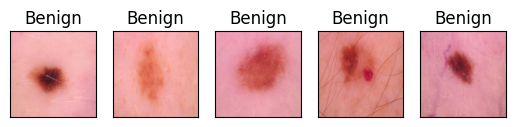

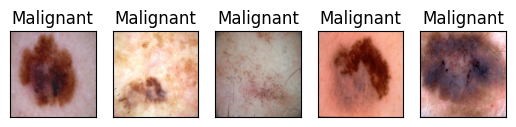

In [ ]:
# Visualizamos algunas imágenes:
def show_sample_images(path, title):
    # Extraemos los nombres de cada imágen (5) hallada en os.listdir(path)
    img_names = os.listdir(path)[:5]
    img_paths = []
    # Generamos los paths a cada imágen
    for name in img_names:
        img_paths.append(os.path.join(path, name))
    # Iteramos cada path y generamos la tira de imágenes
    for i in range(len(img_paths)):
        plt.subplot(1, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = cv2.imread(img_paths[i])
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
    plt.show()

show_sample_images(train_dir_benign, 'Benign')
show_sample_images(train_dir_malignant, 'Malignant')

### Análisis de Intensidad de Píxeles (Histogramas)

1. **Histogramas de Intensidad de Píxeles:**
   - Visualizando los histogramas de las imágenes benignas y malignas, podemos observar la distribución de intensidad de píxeles en cada clase.
   - **Análisis:** Comparar la distribución de intensidad de píxeles entre las imágenes benignas y malignas. Por ejemplo, podemos buscar diferencias significativas en términos de rango de intensidad, picos de frecuencia, etc.

2. **Media y Varianza de Intensidad:**
   - Calcular la media y la varianza de la intensidad de píxeles en cada clase.
   - **Análisis:** Comparar la media y la varianza de las imágenes benignas y malignas. Las malignas podrían mostrar una mayor variabilidad o una intensidad media diferente debido a características específicas de los lunares malignos.

### Análisis de Textura

3. **Matriz de Co-ocurrencia de Píxeles (GLCM):**
   - Calcular la matriz de co-ocurrencia de píxeles para cada imagen y luego promediar o sumar las matrices para obtener características de textura.
   - **Análisis:** Observar diferencias en las características de textura entre las imágenes benignas y malignas. Las malignas pueden mostrar texturas más irregulares o patrones más complejos.

### Análisis Morfológico

4. **Características Morfológicas:**
   - Calcular características como el área, la circularidad, el perímetro, etc., para cada lunar.
   - **Análisis:** Comparar las características morfológicas de los lunares benignos y malignos. Los lunares malignos pueden tener un área mayor, una forma más irregular, etc.

### Análisis de Color

5. **Histogramas de Color (si aplica):**
   - Si las imágenes son a color, se pueden analizar los histogramas de los canales de color.
   - **Análisis:** Comparar los histogramas de color entre las imágenes benignas y malignas. Podría haber diferencias significativas en la distribución del color entre las dos clases.

### Análisis General

6. **Distribución y Balance de Clases:**
   - Revisar la distribución de imágenes entre las clases benignas y malignas.
   - **Análisis:** Asegurarse de que las clases estén balanceadas para evitar sesgos en el modelo de clasificación.

### Consideraciones Especiales

7. **Preprocesamiento:**
   - Verificar la calidad de las imágenes y considerar cualquier necesidad de preprocesamiento adicional, como corrección de iluminación, normalización, etc.

8. **Visualización de Ejemplos:**
   - Seleccionar ejemplos representativos de cada clase y visualizarlos para comprender las características visuales distintivas.

***1. Histogramas de Intensidad de Píxeles***

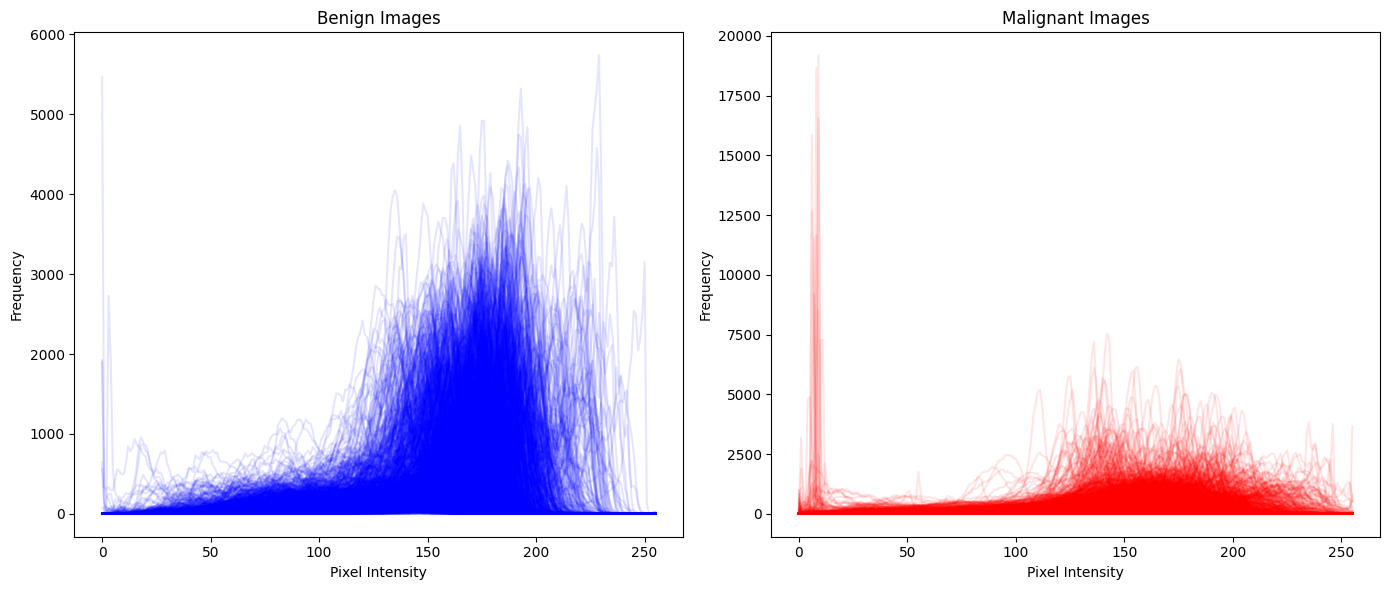

In [ ]:
# Función para obtener el histograma de una imagen
def get_image_histogram(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    return hist.flatten()

# Obtener los histogramas de intensidad de píxeles para todas las imágenes
benign_histograms = [get_image_histogram(path) for path in benign_paths]
malignant_histograms = [get_image_histogram(path) for path in malignant_paths]

# Mostrar los histogramas en un gráfico
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for hist in benign_histograms:
    plt.plot(hist, color='blue', alpha=0.1)
plt.title('Benign Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
for hist in malignant_histograms:
    plt.plot(hist, color='red', alpha=0.1)
plt.title('Malignant Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**2. Media y Varianza de Intensidad de Píxeles**

In [ ]:
# Función para obtener la media y la varianza de intensidad de píxeles
def get_mean_var_intensity(images):
    means = []
    variances = []
    for img_path in images:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        means.append(np.mean(img))
        variances.append(np.var(img))
    return means, variances

# Obtener la media y la varianza de intensidad de píxeles para todas las imágenes
benign_means, benign_variances = get_mean_var_intensity(benign_paths)
malignant_means, malignant_variances = get_mean_var_intensity(malignant_paths)

# Imprimir resultados
print("Benign Images:")
print(f"Mean intensity: {np.mean(benign_means)}, Variance: {np.mean(benign_variances)}")
print("Malignant Images:")
print(f"Mean intensity: {np.mean(malignant_means)}, Variance: {np.mean(malignant_variances)}")

Benign Images:
Mean intensity: 156.60704843949298, Variance: 836.629545417883
Malignant Images:
Mean intensity: 150.7564311967738, Variance: 1141.3191728164686


**3. Matriz de Co-ocurrencia de Píxeles (GLCM)**

In [ ]:
# Función para obtener la matriz de co-ocurrencia y características de textura
def get_texture_features(paths):
    textures = []
    for img_path in paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        glcm = graycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast').flatten().mean()
        dissimilarity = graycoprops(glcm, 'dissimilarity').flatten().mean()
        homogeneity = graycoprops(glcm, 'homogeneity').flatten().mean()
        energy = graycoprops(glcm, 'energy').flatten().mean()
        correlation = graycoprops(glcm, 'correlation').flatten().mean()
        textures.append([contrast, dissimilarity, homogeneity, energy, correlation])
    return textures

# Obtener características de textura para imágenes benignas y malignas
benign_texture_features = get_texture_features(benign_paths)
malignant_texture_features = get_texture_features(malignant_paths)

# Imprimir resultados
# Características de textura de imágenes benignas y malignas:
# Contraste, Disimilitud o Diferencia, Homogeneidad, Energía y Correlación

print("Benign Images Texture Features:")
print(f"Contrast: {np.mean([feat[0] for feat in benign_texture_features])}")
print(f"Dissimilarity: {np.mean([feat[1] for feat in benign_texture_features])}")
print(f"Homogeneity: {np.mean([feat[2] for feat in benign_texture_features])}")
print(f"Energy: {np.mean([feat[3] for feat in benign_texture_features])}")
print(f"Correlation: {np.mean([feat[4] for feat in benign_texture_features])}")

print("\nMalignant Images Texture Features:")
print(f"Contrast: {np.mean([feat[0] for feat in malignant_texture_features])}")
print(f"Dissimilarity: {np.mean([feat[1] for feat in malignant_texture_features])}")
print(f"Homogeneity: {np.mean([feat[2] for feat in malignant_texture_features])}")
print(f"Energy: {np.mean([feat[3] for feat in malignant_texture_features])}")
print(f"Correlation: {np.mean([feat[4] for feat in malignant_texture_features])}")

Benign Images Texture Features:
Contrast: 32.38227369692166
Dissimilarity: 3.2149427426569397
Homogeneity: 0.3269883943840943
Energy: 0.04890785051040823
Correlation: 0.9748802813110766

Malignant Images Texture Features:
Contrast: 56.176004640491826
Dissimilarity: 4.209538542617532
Homogeneity: 0.28397349236577835
Energy: 0.04218651112070876
Correlation: 0.9577672026791049


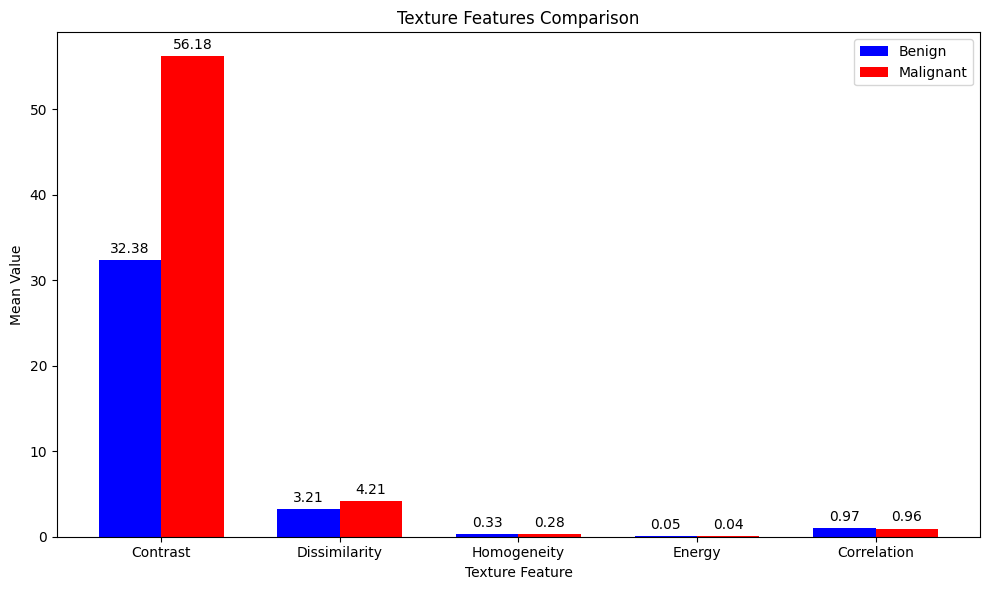

In [ ]:
# Resultados en diagrama de barras para ser visualizado
# Calcular medias de características de textura
benign_means = np.mean(benign_texture_features, axis=0)
malignant_means = np.mean(malignant_texture_features, axis=0)

# Etiquetas para las características
labels = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']

# Crear gráfico de barras para comparar características de textura entre benignas y malignas
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, benign_means, width, label='Benign', color='blue')
rects2 = ax.bar(x + width/2, malignant_means, width, label='Malignant', color='red')

ax.set_xlabel('Texture Feature')
ax.set_ylabel('Mean Value')
ax.set_title('Texture Features Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

**4. Características Morfológicas**

In [ ]:
# Función para obtener características morfológicas
def get_morphology_features(paths):
    morphology = []
    for img_path in paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        label_img = measure.label(img)
        regions = measure.regionprops(label_img)
        area = regions[0].area
        perimeter = regions[0].perimeter
        solidity = regions[0].solidity
        eccentricity = regions[0].eccentricity
        morphology.append([area, perimeter, solidity, eccentricity])
    return morphology

# Obtener características morfológicas para imágenes benignas y malignas
benign_morphology_features = get_morphology_features(benign_paths)
malignant_morphology_features = get_morphology_features(malignant_paths)

# Imprimir resultados
# Características morfológicas de imágenes benignas: Área, Perímetro, Solidez, Excentricidad.

print("Benign Images Morphology Features:")
print(f"Area: {np.mean([feat[0] for feat in benign_morphology_features])}")
print(f"Perimeter: {np.mean([feat[1] for feat in benign_morphology_features])}")
print(f"Solidity: {np.mean([feat[2] for feat in benign_morphology_features])}")
print(f"Eccentricity: {np.mean([feat[3] for feat in benign_morphology_features])}")

print("\nMalignant Images Morphology Features:")
print(f"Area: {np.mean([feat[0] for feat in malignant_morphology_features])}")
print(f"Perimeter: {np.mean([feat[1] for feat in malignant_morphology_features])}")
print(f"Solidity: {np.mean([feat[2] for feat in malignant_morphology_features])}")
print(f"Eccentricity: {np.mean([feat[3] for feat in malignant_morphology_features])}")

Benign Images Morphology Features:
Area: 2.1743055555555557
Perimeter: 0.96890096355396
Solidity: 0.9604208327451299
Eccentricity: 0.3678888922282052

Malignant Images Morphology Features:
Area: 50.953216374269005
Perimeter: 6.790569313100376
Solidity: 0.969624167094493
Eccentricity: 0.2743389542127535


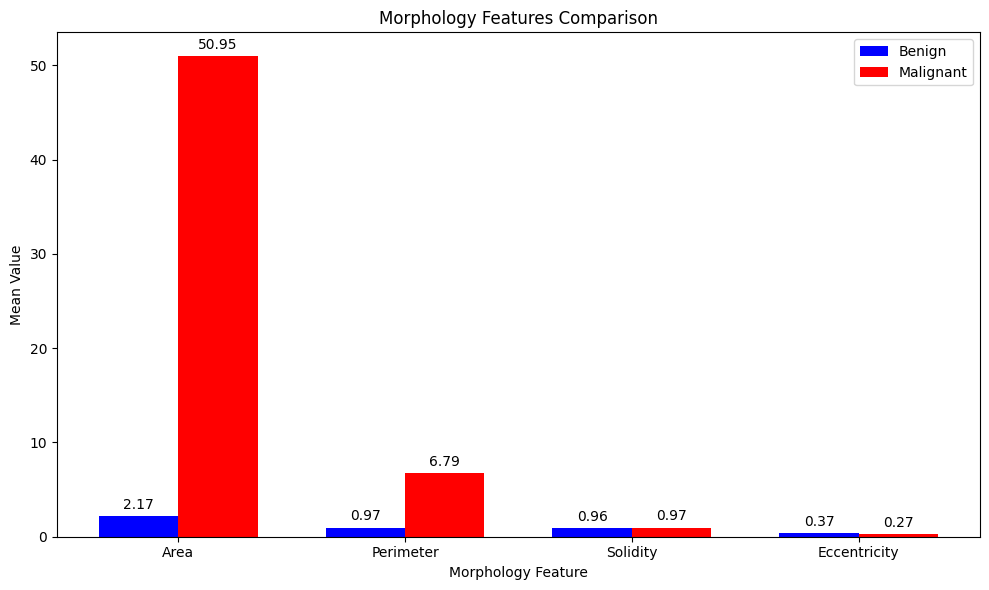

In [ ]:
# Comparación de características Morfologicas, pero muestra resultados en diagrama de barras para ser visualizado

# Calcular medias de características Morfologicas:
benign_means = np.mean(benign_morphology_features, axis=0)
malignant_means = np.mean(malignant_morphology_features, axis=0)

# Etiquetas para las características
labels = ['Area', 'Perimeter', 'Solidity', 'Eccentricity']

# Crear gráfico de barras para comparar características morfologicas entre benignas y malignas
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, benign_means, width, label='Benign', color='blue')
rects2 = ax.bar(x + width/2, malignant_means, width, label='Malignant', color='red')

ax.set_xlabel('Morphology Feature')
ax.set_ylabel('Mean Value')
ax.set_title('Morphology Features Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

 El gráfico de barras compara las características morfológicas promedio entre las imágenes benignas y malignas. Cada barra representa una métrica morfológica (área, perímetro, solidez y excentricidad), con colores distintos para cada clase (benigna en azul y maligna en rojo).

Este tipo de visualización es útil para identificar diferencias significativas en las características morfológicas extraídas de las imágenes, lo que puede ser relevante para la clasificación automática de lunares benignos y malignos.

**5. Histogramas de Color**

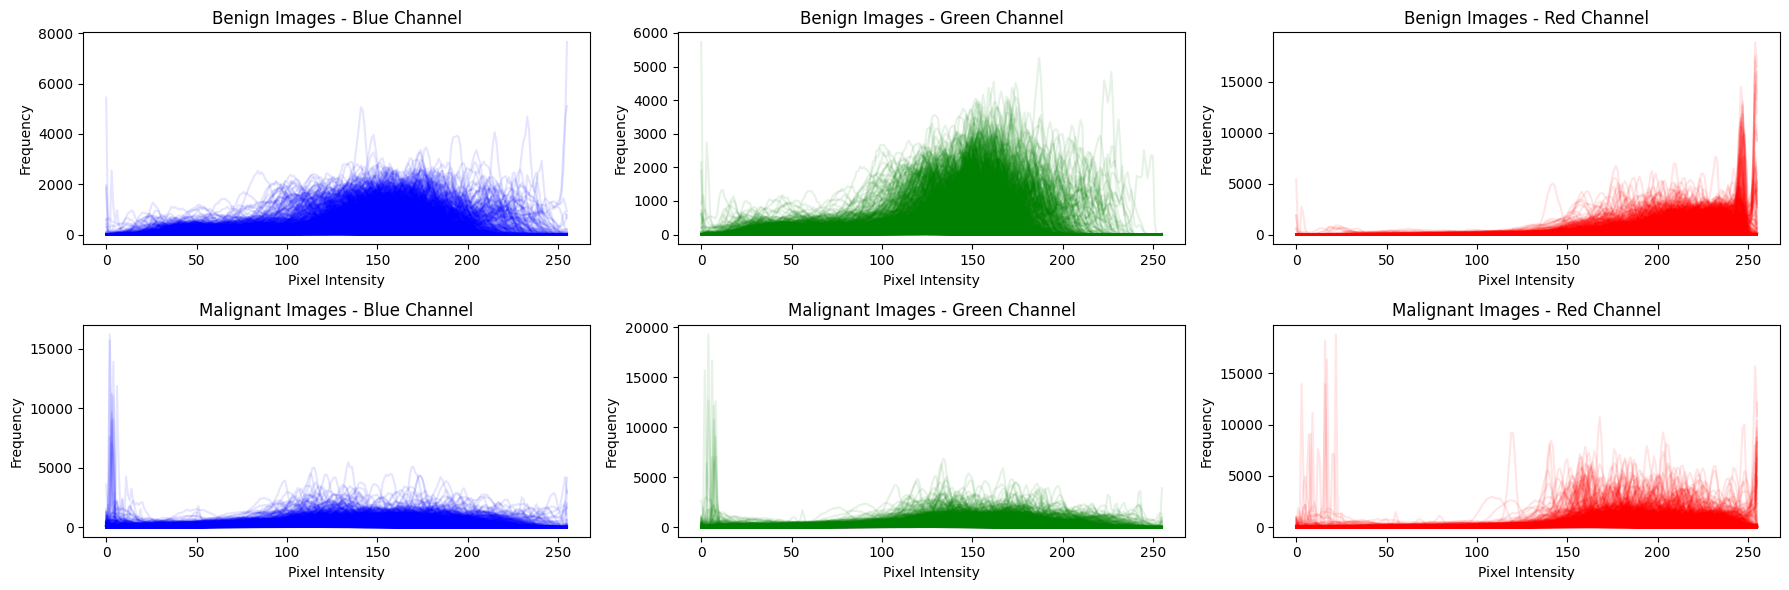

In [ ]:
# Función para obtener el histograma de color de una imagen
def get_color_histogram(image_path):
    img = cv2.imread(image_path)
    hist_b = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [256], [0, 256])
    return hist_b.flatten(), hist_g.flatten(), hist_r.flatten()

# Obtener los histogramas de color para imágenes benignas y malignas
benign_color_histograms_b = []
benign_color_histograms_g = []
benign_color_histograms_r = []
malignant_color_histograms_b = []
malignant_color_histograms_g = []
malignant_color_histograms_r = []

for img_path in benign_paths:
    hist_b, hist_g, hist_r = get_color_histogram(img_path)
    benign_color_histograms_b.append(hist_b)
    benign_color_histograms_g.append(hist_g)
    benign_color_histograms_r.append(hist_r)

for img_path in malignant_paths:
    hist_b, hist_g, hist_r = get_color_histogram(img_path)
    malignant_color_histograms_b.append(hist_b)
    malignant_color_histograms_g.append(hist_g)
    malignant_color_histograms_r.append(hist_r)

# Mostrar los histogramas de color en un gráfico
plt.figure(figsize=(18, 6))

plt.subplot(2, 3, 1)
for hist in benign_color_histograms_b:
    plt.plot(hist, color='blue', alpha=0.1)
plt.title('Benign Images - Blue Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
for hist in benign_color_histograms_g:
    plt.plot(hist, color='green', alpha=0.1)
plt.title('Benign Images - Green Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
for hist in benign_color_histograms_r:
    plt.plot(hist, color='red', alpha=0.1)
plt.title('Benign Images - Red Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
for hist in malignant_color_histograms_b:
    plt.plot(hist, color='blue', alpha=0.1)
plt.title('Malignant Images - Blue Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
for hist in malignant_color_histograms_g:
    plt.plot(hist, color='green', alpha=0.1)
plt.title('Malignant Images - Green Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
for hist in malignant_color_histograms_r:
    plt.plot(hist, color='red', alpha=0.1)
plt.title('Malignant Images - Red Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

**6. Análisis General**
Para completar el análisis exploratorio, también podemos considerar algunos aspectos generales adicionales:

**Distribución y Balance de Clases**

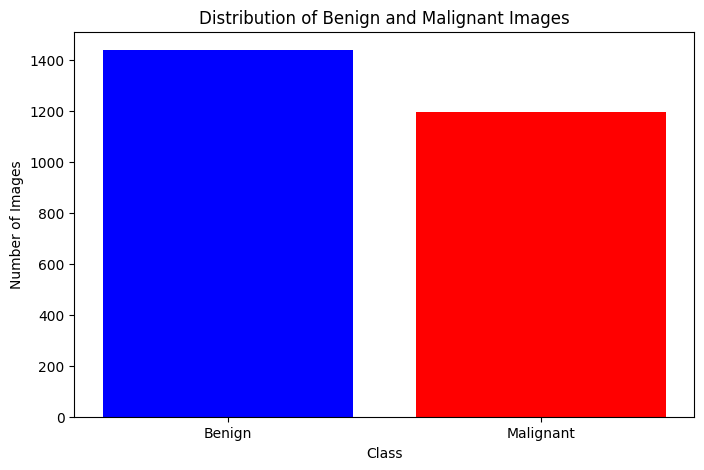

In [ ]:
# Contar el número de imágenes en cada clase
num_benign = len(benign_paths)
num_malignant = len(malignant_paths)

# Mostrar el balance de clases
plt.figure(figsize=(8, 5))
plt.bar(['Benign', 'Malignant'], [num_benign, num_malignant], color=['blue', 'red'])
plt.title('Distribution of Benign and Malignant Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

---
# 3. Preparación de los Datos


Para la etapa de **Preparación de los Datos** para clasificación de lunares
benignos y malignos, además del preprocesamiento de imágenes y la creación de generadores de datos, hay varias tareas que se podría considerar:

1. Segmentación de Imágenes:
•	Segmentación de la región de interés (ROI) que contiene el lunar para mejorar la precisión del modelo.
•	Aplicación de técnicas de segmentación para eliminar el fondo no relevante.

2. Aumentación de Datos:
•	Aplicación de técnicas de aumentación de datos (rotación, cambio de escala, recorte, etc.) para aumentar la variabilidad del conjunto de datos.
•	Aumentación específica para imágenes médicas, como el cambio de iluminación simulando diferentes condiciones.

3. Normalización Avanzada:
•	Normalización estadística avanzada, como normalización por imagen o batch normalization, para mejorar la convergencia y el rendimiento del modelo.

4. Selección de Características:
•	Extracción y selección de características relevantes para la clasificación de lunares (texturas, características morfológicas, características de bordes, etc.).
•	Reducción de dimensionalidad si el número de características es elevado.

5. Procesamiento de Imágenes Médicas:
•	Consideración de técnicas específicas para procesamiento de imágenes médicas, como la corrección de contraste y la normalización de intensidad.

7. Etiquetado Automático o Semi-Automático:
•	Implementación de técnicas de etiquetado automático o semiautomático para acelerar el proceso de etiquetado de imágenes si el conjunto de datos es grande.


###	Segmentación de ROI de interés:
*   Convertimos la imagen a escala de grises.
*   Aplicamos umbralización binaria inversa para resaltar la región de interés.
*   Encontramos los contornos y seleccionamos el contorno más grande.
*   Extraemos la región delimitada por el contorno más grande.Elemento de lista

In [ ]:
# Función para segmentar la región de interés (ROI)
def segment_roi(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        img_roi = img[y:y+h, x:x+w]
        return img_roi
    else:
        return img  # Devuelve la imagen original si no se encuentra contorno

###	Aumentación de Datos:

In [ ]:
# Simple operación de flip horizontal como ejemplo de aumentación:
def augment_data(image):
    augmented_image = cv2.flip(image, 1)  # Ejemplo: Flip horizontal
    return augmented_image  # Imagen aumentada

In [ ]:
# Generación de Datos:
# Parámetros de imagen
img_size = 224  # Tamaño requerido por VGG16

# Crear generadores de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% entrenamiento, 20% validación
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary'
)

Found 215 images belonging to 2 classes.
Found 53 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


###	Preprocesamiento:
*	Redimensionamos la imagen.
*	Convertimos la imagen a RGB.
*	Normalizamos los valores de píxeles al rango [0, 1].

In [ ]:
# Función para preprocesar una imagen
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))  # Redimensionar la imagen a un tamaño específico
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir a RGB (si se está utilizando VGG16, por ejemplo)
    img = img / 255.0  # Normalizar los valores de píxeles al rango [0, 1]
    return img

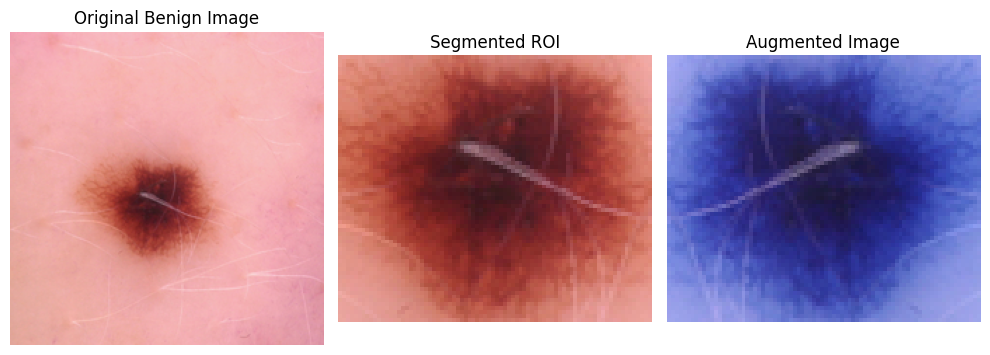

In [ ]:
# Ejemplo de segmentación y aumentación de datos
# Segmentar y aumentar una imagen benigna
sample_benign_image = benign_paths[0]
roi_segmented = segment_roi(sample_benign_image)
augmented_image = augment_data(roi_segmented)

# Ejemplo de preprocesamiento básico de imagen
sample_preprocessed_image = preprocess_image(sample_benign_image)

# Mostrar ejemplos de imágenes
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread(sample_benign_image), cv2.COLOR_BGR2RGB))
plt.title('Original Benign Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(roi_segmented, cv2.COLOR_BGR2RGB))
plt.title('Segmented ROI')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(augmented_image)
plt.title('Augmented Image')
plt.axis('off')

plt.tight_layout()
plt.show()

---
# 4. Modelado

- Cargar el modelo VGG16 preentrenado.
- Añadir capas de clasificación en la parte superior.
- Compilar el modelo.

In [ ]:
# Cargar el modelo VGG16 preentrenado sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas de clasificación
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Añadir dropout para evitar overfitting
x = Dense(1, activation='sigmoid')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

---
# 5. Evaluación

## Entrenamiento y Evaluación

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')

Epoch 1/5
7/7 [==============================] - 11s 1s/step - loss: 0.7159 - accuracy: 0.5767 - val_loss: 0.5810 - val_accuracy: 0.5849
Epoch 2/5
7/7 [==============================] - 4s 617ms/step - loss: 0.5134 - accuracy: 0.7163 - val_loss: 0.3892 - val_accuracy: 0.8679
Epoch 3/5
7/7 [==============================] - 5s 745ms/step - loss: 0.3939 - accuracy: 0.8326 - val_loss: 0.3384 - val_accuracy: 0.8679
Epoch 4/5
7/7 [==============================] - 5s 630ms/step - loss: 0.3943 - accuracy: 0.8186 - val_loss: 0.3226 - val_accuracy: 0.8302
Epoch 5/5
5/5 [==============================] - 1s 131ms/step - loss: 0.4501 - accuracy: 0.7676
Test Accuracy: 0.7676056623458862


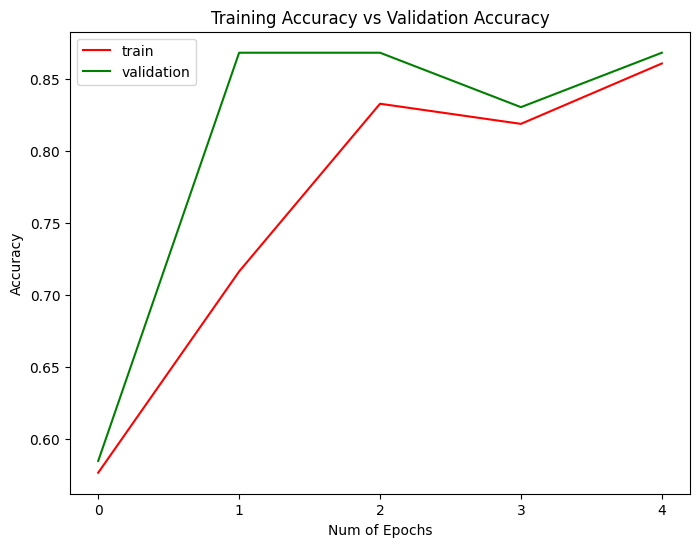

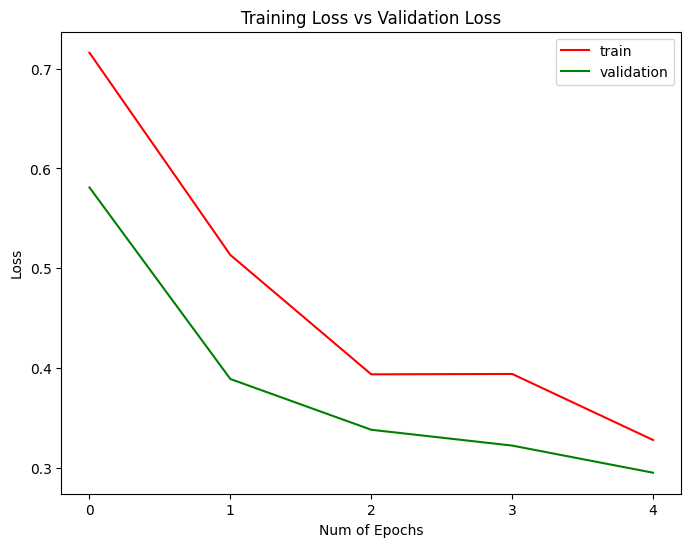

In [ ]:
# Gráfico de las métricas de validación:
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 5, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 5, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

plt.show()

## Guardado del Modelo:

In [ ]:
# Guardar el modelo entrenado
model.save('/content/gdrive/MyDrive/mole_classifier_vgg16.h5')

# Cargar y usar el modelo para predicciones
model = tf.keras.models.load_model('/content/gdrive/MyDrive/mole_classifier_vgg16.h5')

## Predicción

In [ ]:
# Definir el tamaño de la imagen
img_size = 224

# Cargar el modelo
model_path = '/content/gdrive/MyDrive/mole_classifier_vgg16.h5'
model = load_model(model_path)

def resize_and_display_image(image_path, output_path):
    # Leer la imagen desde la ruta proporcionada
    img = cv2.imread(image_path)

    # Verificar si la imagen se leyó correctamente
    if img is None:
        raise ValueError("Error al cargar la imagen. Verifica la ruta y el nombre del archivo.")

    # Redimensionar la imagen a las dimensiones requeridas (224x224)
    img_resized = cv2.resize(img, (img_size, img_size))

    # Guardar la imagen redimensionada
    cv2.imwrite(output_path, img_resized)
    print(f"Imagen redimensionada guardada en: {output_path}")

    # Mostrar la imagen redimensionada
    cv2_imshow(img_resized)

def predict_image(image_path):
    # Leer la imagen desde la ruta proporcionada
    img = cv2.imread(image_path)

    # Verificar si la imagen se leyó correctamente
    if img is None:
        raise ValueError("Error al cargar la imagen. Verifica la ruta y el nombre del archivo.")

    # Redimensionar la imagen a las dimensiones requeridas por el modelo (224x224)
    img = cv2.resize(img, (img_size, img_size))

    # Expandir las dimensiones de la imagen para que coincidan con el formato de entrada del modelo
    # y normalizar los valores de los píxeles a un rango de [0, 1]
    img = np.expand_dims(img, axis=0) / 255.0

    # Realizar la predicción con el modelo
    prediction = model.predict(img)

    # Interpretar la predicción: si el valor es mayor a 0.5, se considera maligno; de lo contrario, benigno
    return 'Malignant' if prediction[0][0] > 0.5 else 'Benign'

# Ruta de la imagen original y la imagen redimensionada
original_image_path = '/content/gdrive/MyDrive/dataset/data/test/benign/example.jpg'
resized_image_path = '/content/gdrive/MyDrive/dataset/data/test/benign/example_resized.jpg'

# Redimensionar y mostrar la imagen
resize_and_display_image(original_image_path, resized_image_path)

# Realizar la predicción utilizando la imagen redimensionada
try:
    prediction = predict_image(resized_image_path)
    print(f"La predicción para la imagen es: {prediction}")
except ValueError as e:
    print(e)

---
# 6. Despliegue

- Implementar el modelo en un entorno de producción.
- Crear una interfaz de usuario para subir imágenes y obtener predicciones.